# Ingestão de Dados Sentinel para o Protótipo NAIÁ

Este notebook realiza a ingestão de imagens Sentinel-1 (VV/VH) e Sentinel-2 (RGB+NIR) para Barão Geraldo, Campinas (SP), no contexto do Hackathon CopernicusLAC Panamá 2025. A área de interesse é centrada na Unicamp (-47.063, -22.821), com bounding box [-47.10, -22.85, -47.03, -22.78] (~20 km²). O objetivo é obter imagens para análise de criadouros do *Aedes aegypti*.

## Configuração
- **Ambiente**: `naia-env` (Python 3.12.7).
- **Repositório**: `/home/lorhan/git/CorpenicusHackthon/`.
- **Período**: 2024-06-29 a 2024-07-29 (2025 não disponível).
- **Saídas**: 
  - `data/sentinel1_unicamp.tiff` (Sentinel-1, VV/VH).
  - `data/sentinel2_unicamp.tiff` (Sentinel-2, RGB+NIR).
  - `data/s1_preview.png` e `data/s2_preview.png` (visualizações).

## Pré-requisitos
1. Ative o ambiente: `source naia-env/bin/activate`.
2. Instale dependências:
   ```bash
   pip install sentinelhub geopandas rasterio matplotlib requests python-dotenv
   pip freeze > requirements.txt
   ```
3. Configure `.env` com `CLIENT_ID` e `CLIENT_SECRET_ID` (Copernicus CDSE).
4. Execute as células abaixo sequencialmente.

In [1]:
# Importações
import os
from dotenv import load_dotenv
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, BBox, CRS, MimeType
import requests
import glob
import matplotlib.pyplot as plt
import rasterio

# Configurar diretório de saída
os.makedirs('data', exist_ok=True)
print('✓ Diretório data/ criado ou já existente')

/home/lorhan/git/CorpenicusHackthon/naia-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Diretório data/ criado ou já existente


## 1. Carregamento das Credenciais

Carregamos as credenciais do Copernicus Data Space Ecosystem (CDSE) a partir do arquivo `.env`. Certifique-se de que `CLIENT_ID` e `CLIENT_SECRET_ID` estão configurados.

In [2]:
load_dotenv()
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET_ID')
if not client_id or not client_secret:
    raise ValueError('❌ Credenciais CLIENT_ID ou CLIENT_SECRET_ID não encontradas no .env')
print('✓ Credenciais carregadas do arquivo .env')
print(f'Client ID: {client_id[:10]}...')

✓ Credenciais carregadas do arquivo .env
Client ID: sh-02df45a...


## 2. Configuração do SentinelHub

Configuramos o acesso ao CDSE com URLs específicas para autenticação e download.

In [3]:
def setup_sentinelhub_config():
    """Configura e autentica no Copernicus Data Space Ecosystem."""
    config = SHConfig()
    config.sh_client_id = client_id.strip()
    config.sh_client_secret = client_secret.strip()
    config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
    config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
    return config

config = setup_sentinelhub_config()
print('✓ Configuração do SentinelHub criada')

✓ Configuração do SentinelHub criada


## 3. Teste de Autenticação

Testamos a autenticação com o CDSE para garantir que as credenciais são válidas.

In [4]:
def test_authentication(config):
    """Testa a conexão com o Copernicus CDSE."""
    try:
        response = requests.post(
            config.sh_token_url,
            data={
                'grant_type': 'client_credentials',
                'client_id': config.sh_client_id,
                'client_secret': config.sh_client_secret
            },
            headers={'Content-Type': 'application/x-www-form-urlencoded'}
        )
        response.raise_for_status()
        print('✓ Autenticação no Copernicus CDSE bem-sucedida!')
        return True
    except Exception as e:
        print(f'❌ Falha na autenticação: {e}')
        return False

auth_success = test_authentication(config)

✓ Autenticação no Copernicus CDSE bem-sucedida!


## 4. Definição da Área de Interesse

Definimos a bounding box para Barão Geraldo, centrada na Unicamp (-47.063, -22.821).

In [5]:
unicamp_bbox = BBox(bbox=[-47.10, -22.85, -47.03, -22.78], crs=CRS.WGS84)
print('✓ Área de interesse definida:')
print(f'  Longitude: {unicamp_bbox.min_x}° a {unicamp_bbox.max_x}°')
print(f'  Latitude: {unicamp_bbox.min_y}° a {unicamp_bbox.max_y}°')
print('  Região: Barão Geraldo, Campinas (SP), centrada na Unicamp')

✓ Área de interesse definida:
  Longitude: -47.1° a -47.03°
  Latitude: -22.85° a -22.78°
  Região: Barão Geraldo, Campinas (SP), centrada na Unicamp


## 5. Download de Sentinel-1 (VV/VH)

Baixamos a imagem Sentinel-1 com polarizações VV e VH, resolução 512x512 pixels, para o período de 2024-06-29 a 2024-07-29.

In [6]:
if auth_success:
    evalscript_s1 = """
    //VERSION=3
    function setup() {
        return { input: ['VV', 'VH'], output: { bands: 2 } };
    }
    function evaluatePixel(sample) {
        return [sample.VV, sample.VH];
    }
    """
    s1_request = SentinelHubRequest(
        data_folder='data',
        evalscript=evalscript_s1,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW.define_from(
                    name='S1IW', service_url='https://sh.dataspace.copernicus.eu'
                ),
                time_interval=('2024-06-29', '2024-07-29')
            )
        ],
        responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
        bbox=unicamp_bbox,
        size=(512, 512),
        config=config
    )
    print('📡 Iniciando download da imagem Sentinel-1 (VV/VH)...')
    try:
        s1_request.save_data()
        tiff_files = sorted(glob.glob('data/**/response.tiff', recursive=True), key=os.path.getmtime, reverse=True)
        if tiff_files:
            os.rename(tiff_files[0], 'data/sentinel1_unicamp.tiff')
            s1_data_path = 'data/sentinel1_unicamp.tiff'
            print(f'✓ Download concluído: {s1_data_path}')
        else:
            print('❌ Download realizado, mas nenhum arquivo TIFF encontrado.')
            s1_data_path = None
    except Exception as e:
        print(f'❌ Erro no download Sentinel-1: {e}')
        s1_data_path = None
else:
    print('❌ Pulando download Sentinel-1 devido à falha na autenticação')
    s1_data_path = None

📡 Iniciando download da imagem Sentinel-1 (VV/VH)...
✓ Download concluído: data/sentinel1_unicamp.tiff


## 6. Visualização de Sentinel-1

Visualizamos as bandas VV e VH da imagem Sentinel-1 baixada.

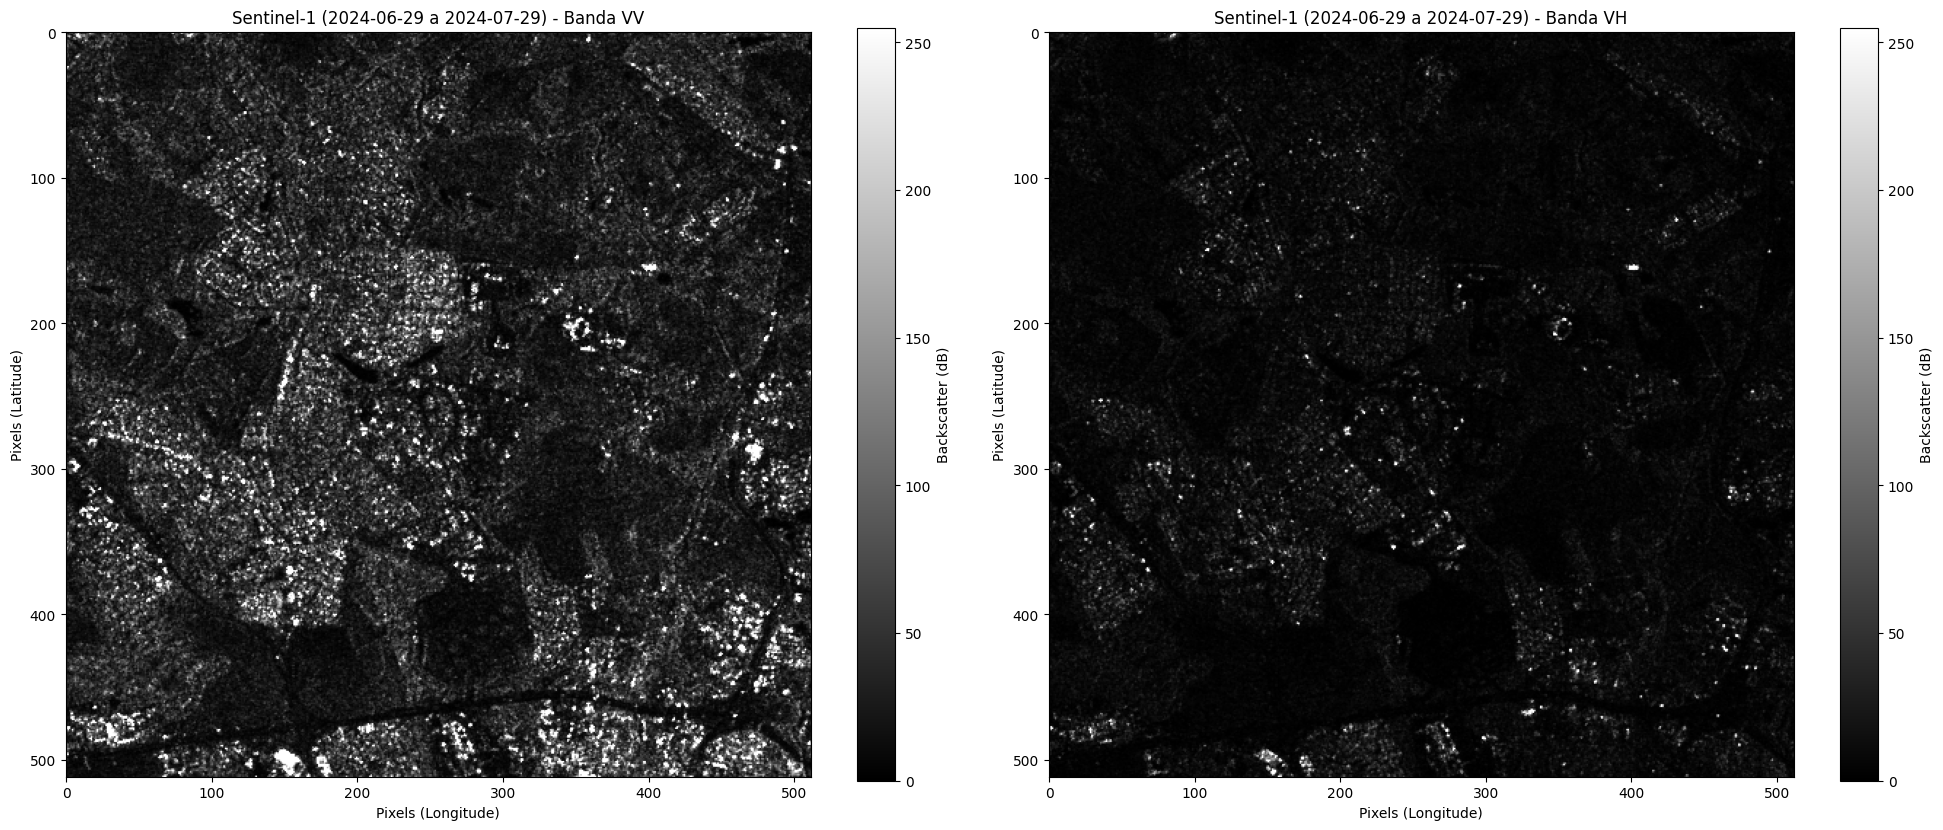

✓ Visualização salva em data/s1_preview.png
  Dimensões: (2, 512, 512)
  Valores mín/máx: 0.00 / 255.00


In [7]:
def visualize_sentinel_image(data_path, title, output_file):
    """Visualiza uma imagem Sentinel baixada."""
    if not data_path or not os.path.exists(data_path):
        print(f'❌ Arquivo {data_path} não encontrado')
        return
    try:
        with rasterio.open(data_path) as src:
            image = src.read()  # Ler todas as bandas
            fig, axes = plt.subplots(1, len(image), figsize=(10 * len(image), 8))
            if len(image) == 1:
                axes = [axes]
            for i, band in enumerate(image):
                axes[i].imshow(band, cmap='gray')
                axes[i].set_title(f'{title} - Banda {'VV' if i == 0 else 'VH'}', fontsize=12)
                axes[i].set_xlabel('Pixels (Longitude)')
                axes[i].set_ylabel('Pixels (Latitude)')
                plt.colorbar(axes[i].imshow(band, cmap='gray'), ax=axes[i], label='Backscatter (dB)')
            plt.tight_layout()
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.show()
            print(f'✓ Visualização salva em {output_file}')
            print(f'  Dimensões: {image.shape}')
            print(f'  Valores mín/máx: {image.min():.2f} / {image.max():.2f}')
    except Exception as e:
        print(f'❌ Erro na visualização: {e}')

if s1_data_path:
    visualize_sentinel_image(s1_data_path, 'Sentinel-1 (2024-06-29 a 2024-07-29)', 'data/s1_preview.png')

## 7. Download de Sentinel-2 (RGB+NIR)

Baixamos a imagem Sentinel-2 com bandas RGB (B04, B03, B02) e NIR (B08), resolução 512x512 pixels, para o mesmo período.

In [8]:
if auth_success:
    evalscript_s2 = """
    //VERSION=3
    function setup() {
        return { input: ['B02', 'B03', 'B04', 'B08'], output: { bands: 4 } };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02, sample.B08];
    }
    """
    s2_request = SentinelHubRequest(
        data_folder='data',
        evalscript=evalscript_s2,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name='S2L2A', service_url='https://sh.dataspace.copernicus.eu'
                ),
                time_interval=('2024-06-29', '2024-07-29'),
                mosaicking_order='leastCC'
            )
        ],
        responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
        bbox=unicamp_bbox,
        size=(512, 512),
        config=config
    )
    print('📡 Iniciando download da imagem Sentinel-2 (RGB+NIR)...')
    try:
        s2_request.save_data()
        tiff_files = sorted(glob.glob('data/**/response.tiff', recursive=True), key=os.path.getmtime, reverse=True)
        if tiff_files:
            os.rename(tiff_files[0], 'data/sentinel2_unicamp.tiff')
            s2_data_path = 'data/sentinel2_unicamp.tiff'
            print(f'✓ Download concluído: {s2_data_path}')
        else:
            print('❌ Download realizado, mas nenhum arquivo TIFF encontrado.')
            s2_data_path = None
    except Exception as e:
        print(f'❌ Erro no download Sentinel-2: {e}')
        s2_data_path = None
else:
    print('❌ Pulando download Sentinel-2 devido à falha na autenticação')
    s2_data_path = None

📡 Iniciando download da imagem Sentinel-2 (RGB+NIR)...
✓ Download concluído: data/sentinel2_unicamp.tiff


## 8. Visualização de Sentinel-2

Visualizamos as bandas RGB e NIR da imagem Sentinel-2, com uma composição RGB verdadeira e a banda NIR separada.

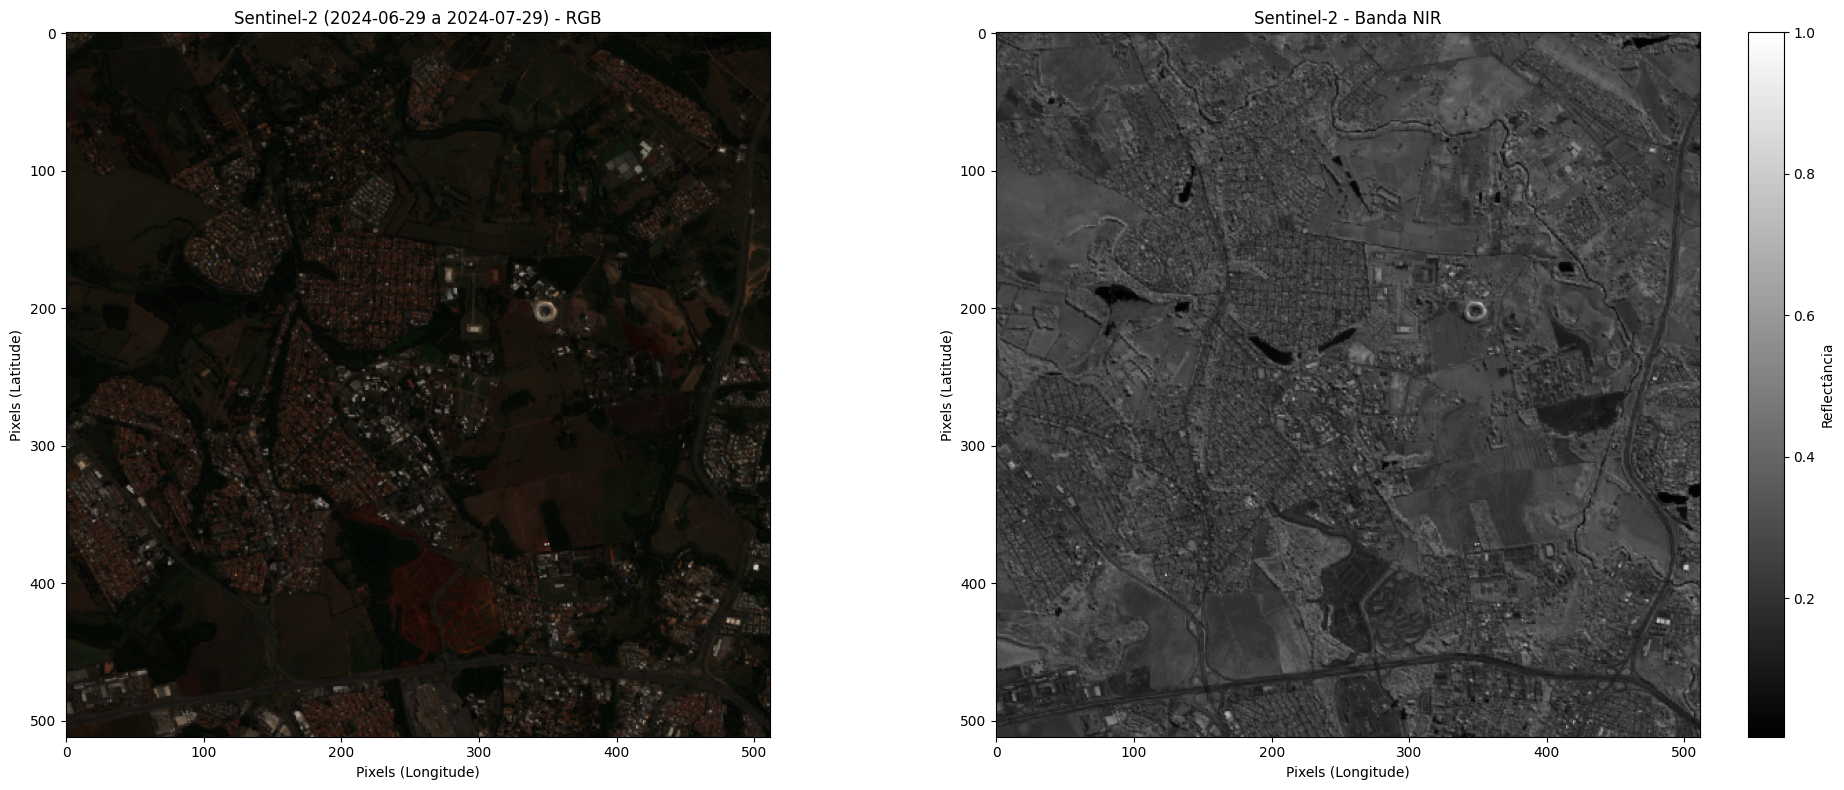

✓ Visualização salva em data/s2_preview.png
  Dimensões: (4, 512, 512)
  Valores mín/máx: 0.00 / 1.00


In [9]:
if s2_data_path:
    try:
        with rasterio.open(s2_data_path) as src:
            image = src.read()  # [B04 (R), B03 (G), B02 (B), B08 (NIR)]
            # Normalizar para visualização (escala 0-1)
            image = image / image.max() if image.max() > 0 else image
            # Composição RGB
            rgb = image[[0, 1, 2]].transpose(1, 2, 0)  # [R, G, B] -> [H, W, C]
            nir = image[3]  # Banda NIR
            fig, axes = plt.subplots(1, 2, figsize=(20, 8))
            axes[0].imshow(rgb)
            axes[0].set_title('Sentinel-2 (2024-06-29 a 2024-07-29) - RGB', fontsize=12)
            axes[0].set_xlabel('Pixels (Longitude)')
            axes[0].set_ylabel('Pixels (Latitude)')
            axes[1].imshow(nir, cmap='gray')
            axes[1].set_title('Sentinel-2 - Banda NIR', fontsize=12)
            axes[1].set_xlabel('Pixels (Longitude)')
            axes[1].set_ylabel('Pixels (Latitude)')
            plt.colorbar(axes[1].imshow(nir, cmap='gray'), ax=axes[1], label='Reflectância')
            plt.tight_layout()
            plt.savefig('data/s2_preview.png', dpi=300, bbox_inches='tight')
            plt.show()
            print(f'✓ Visualização salva em data/s2_preview.png')
            print(f'  Dimensões: {image.shape}')
            print(f'  Valores mín/máx: {image.min():.2f} / {image.max():.2f}')
    except Exception as e:
        print(f'❌ Erro na visualização Sentinel-2: {e}')

## 9. Resumo da Execução

Resumimos o status da autenticação, downloads e arquivos gerados.

In [10]:
print('\n' + '='*50)
print('📋 RESUMO DA EXECUÇÃO')
print('='*50)
print('✓ Autenticação:', 'Bem-sucedida' if auth_success else 'Falhada')

if s1_data_path and os.path.exists(s1_data_path):
    print('✓ Download Sentinel-1: Concluído')
    print(f'  Arquivo: {s1_data_path}')
    print(f'  Tamanho: {os.path.getsize(s1_data_path) / 1024 / 1024:.2f} MB')
else:
    print('❌ Download Sentinel-1: Não realizado')

if s2_data_path and os.path.exists(s2_data_path):
    print('✓ Download Sentinel-2: Concluído')
    print(f'  Arquivo: {s2_data_path}')
    print(f'  Tamanho: {os.path.getsize(s2_data_path) / 1024 / 1024:.2f} MB')
else:
    print('❌ Download Sentinel-2: Não realizado')

print('\n🗂️ ARQUIVOS GERADOS:')
for file in ['data/s1_preview.png', 'data/s2_preview.png', 'data/sentinel1_unicamp.tiff', 'data/sentinel2_unicamp.tiff']:
    if os.path.exists(file):
        print(f'  ✓ {file}')


📋 RESUMO DA EXECUÇÃO
✓ Autenticação: Bem-sucedida
✓ Download Sentinel-1: Concluído
  Arquivo: data/sentinel1_unicamp.tiff
  Tamanho: 0.39 MB
✓ Download Sentinel-2: Concluído
  Arquivo: data/sentinel2_unicamp.tiff
  Tamanho: 0.70 MB

🗂️ ARQUIVOS GERADOS:
  ✓ data/s1_preview.png
  ✓ data/s2_preview.png
  ✓ data/sentinel1_unicamp.tiff
  ✓ data/sentinel2_unicamp.tiff
